In [65]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from lightfm import LightFM
from lightfm.data import Dataset
import random

In [66]:
transactions = pd.read_json("./datasets/datasets/generated_sales_dataset.json", orient="records")
allergy_info = pd.read_json("./datasets/datasets/product_allergy.json", orient="records")

In [67]:
print("Allergy dataset columns:", allergy_info.columns)
allergy_column_name = 'allergic_available'

Allergy dataset columns: Index(['product_code', 'allergic_available'], dtype='object')


In [68]:
if "religious" not in transactions.columns or not set(
    ["buddhism", "hinduism", "islam", "roman_catholic", "other_christian", "other"]
).issubset(transactions["religious"].unique()):
    transactions["religious"] = np.random.choice(
        ["buddhism", "hinduism", "islam", "roman_catholic", "other_christian", "other"],
        size=len(transactions)
    )

In [69]:
np.random.seed(42)
transactions["family_size"] = np.random.choice([1, 2, 3, 4, 5], size=len(transactions))


In [70]:
transactions["customer_age_encoded"] = LabelEncoder().fit_transform(transactions["customer_age_group"])
transactions["province_encoded"] = LabelEncoder().fit_transform(transactions["province"])
transactions["religious_encoded"] = LabelEncoder().fit_transform(transactions["religious"])
transactions["buying_month"] = pd.to_datetime(transactions["buying_date"]).dt.month

In [71]:
all_user_features = []
for age in transactions["customer_age_encoded"].unique():
    all_user_features.append(f"age_{age}")
for fam in transactions["family_size"].unique():
    all_user_features.append(f"fam_{fam}")
for rel in transactions["religious"].unique():
    all_user_features.append(f"rel_{rel}") 
for prov in transactions["province_encoded"].unique():
    all_user_features.append(f"prov_{prov}")

In [72]:
all_item_features = []
for cat in transactions["product_category"].unique():
    all_item_features.append(f"cat_{cat}")

all_items = pd.Series(
    transactions["product_code"].tolist() + allergy_info["product_code"].tolist()
).unique()

In [73]:
data = Dataset()
data.fit(
    transactions["customer_id"].unique(),
    all_items,
    user_features=all_user_features,
    item_features=all_item_features
)

In [74]:
(interactions, weights) = data.build_interactions(
    [(row["customer_id"], row["product_code"], row["quantity"]) for idx, row in transactions.iterrows()]
)

In [75]:
user_features = data.build_user_features([
    (row["customer_id"], [
        f"age_{row['customer_age_encoded']}",
        f"fam_{row['family_size']}",
        f"rel_{row['religious']}",
        f"prov_{row['province_encoded']}"
    ]) for idx, row in transactions.drop_duplicates(subset=["customer_id"]).iterrows()
])

In [76]:
item_features = data.build_item_features([
    (row["product_code"], [f"cat_{row['product_category']}"])
    for idx, row in transactions.drop_duplicates("product_code").iterrows()
])

In [77]:
model = LightFM(loss='warp')
model.fit(interactions, user_features=user_features, item_features=item_features, epochs=30, num_threads=4)

In [78]:
allergy_filter = dict(zip(allergy_info["product_code"], allergy_info[allergy_column_name]))

def filter_products_by_allergy(products, allergic_available):
    filtered = []
    for p in products:
        if allergy_filter.get(p, False) and not allergic_available:
            continue
        filtered.append(p)
    return filtered

In [79]:
def encode_input_age(age_group):
    age_map = {"18-30": 0, "31-45": 1, "46-60": 2, "60+": 3}
    return age_map.get(age_group, 0)

def encode_input_religious(religion):
    religion = religion.strip().lower().replace(" ", "_")
    return f"rel_{religion}"

def encode_input_province(p):
    province_list = transactions["province"].unique().tolist()
    return province_list.index(p) if p in province_list else 0

In [80]:
user_id_map, _, item_id_map, _ = data.mapping()

def recommend_lightfm(customer_id, allergic_available, top_n=6):
    if customer_id not in user_id_map:
        popular_products = transactions.groupby("product_code")["quantity"].sum().sort_values(ascending=False).index.tolist()
        filtered = filter_products_by_allergy(popular_products, allergic_available)
        random.shuffle(filtered)
        return filtered[:top_n]

    user_x = user_id_map[customer_id]
    scores = model.predict(user_x, np.arange(len(item_id_map)), user_features=user_features, item_features=item_features)
    product_scores = [(list(item_id_map.keys())[i], score) for i, score in enumerate(scores)]

    product_scores = [p for p in product_scores if (p[0] in allergy_filter and (allergy_filter[p[0]] or allergic_available))]
    product_scores.sort(key=lambda x: x[1], reverse=True)

    top_items = [p for p, _ in product_scores[:max(3, top_n)]]
    remaining_items = [p for p, _ in product_scores[max(3, top_n):max(10, top_n*2)]]
    n_additional = min(top_n - len(top_items), len(remaining_items))
    random_additional = random.sample(remaining_items, n_additional) if remaining_items else []

    recommended = top_items + random_additional
    random.shuffle(recommended)
    return recommended[:top_n]

In [81]:
def recommend_products_enhanced(customer_id, age, family_size, religious, allergic_available, province):
    lightfm_recs = recommend_lightfm(customer_id, allergic_available, top_n=6)
    prev_products = transactions[transactions["customer_id"] == customer_id]["product_code"].unique().tolist() if customer_id in transactions["customer_id"].unique() else []
    prev_sample = random.sample(prev_products, min(len(prev_products), 3)) if prev_products else []

    recommended = prev_sample
    additions = [p for p in lightfm_recs if p not in recommended]
    recommended.extend(additions[:6 - len(recommended)])

    prod_info = transactions.drop_duplicates("product_code")[["product_code", "product_name", "product_category"]]
    recommended_info = prod_info[prod_info["product_code"].isin(recommended)][["product_name", "product_category"]]

    return recommended_info.sample(frac=1).to_dict(orient="records")

In [82]:
example_output = recommend_products_enhanced(
    customer_id=1,
    age="31-45",
    family_size=3,
    religious="islam",
    allergic_available=False,
    province="Sabaragamuwa"
)
print(example_output)

[{'product_name': 'Frozen Shellfish', 'product_category': 'Frozen Meat & Seafood'}, {'product_name': 'Frozen Fish Fillets', 'product_category': 'Frozen Meat & Seafood'}, {'product_name': 'Tuna', 'product_category': 'Fish'}, {'product_name': 'Cod', 'product_category': 'Fish'}, {'product_name': 'Salmon Fillets', 'product_category': 'Fish'}, {'product_name': 'Whole Fish (Seer Fish)', 'product_category': 'Fish'}]


In [83]:
from lightfm.evaluation import precision_at_k, recall_at_k
import matplotlib.pyplot as plt

# Split train-test
from sklearn.model_selection import train_test_split
train_interactions, test_interactions = train_test_split(
    [(row["customer_id"], row["product_code"], row["quantity"]) for idx, row in transactions.iterrows()],
    test_size=0.2,
    random_state=42
)

train, _ = data.build_interactions(train_interactions)
test, _ = data.build_interactions(test_interactions)

# Refit model for evaluation
model = LightFM(loss='warp')
model.fit(train, user_features=user_features, item_features=item_features, epochs=30, num_threads=4)

# Compute precision and recall
precision = precision_at_k(model, test, user_features=user_features, item_features=item_features, k=5).mean()
recall = recall_at_k(model, test, user_features=user_features, item_features=item_features, k=5).mean()

print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

Precision@5: 0.0934
Recall@5: 0.4308


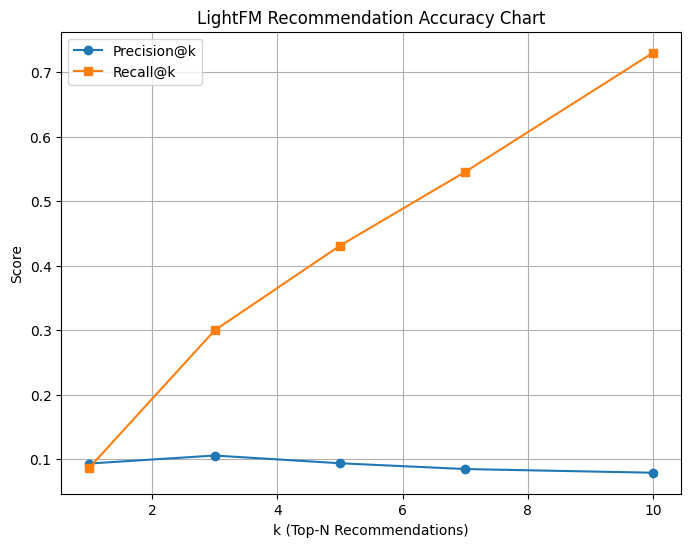

In [84]:
k_values = [1, 3, 5, 7, 10]
precisions = []
recalls = []

for k in k_values:
    p = precision_at_k(model, test, user_features=user_features, item_features=item_features, k=k).mean()
    r = recall_at_k(model, test, user_features=user_features, item_features=item_features, k=k).mean()
    precisions.append(p)
    recalls.append(r)

plt.figure(figsize=(8, 6))
plt.plot(k_values, precisions, marker='o', label='Precision@k')
plt.plot(k_values, recalls, marker='s', label='Recall@k')
plt.title('LightFM Recommendation Accuracy Chart')
plt.xlabel('k (Top-N Recommendations)')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.show()